In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd "./drive/MyDrive/IE7500_NLP_Group7/nlp-getting-started"

/content/drive/MyDrive/IE7500_NLP_Group7/nlp-getting-started


In [ ]:
import pandas as pd
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    get_scheduler
)
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

In [ ]:
%autosave 180

Autosaving every 180 seconds


In [ ]:
class DisasterTweetDataset(Dataset):
    """Dataset class for disaster tweets"""

    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        # Tokenize
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }


In [ ]:
class DisasterTweetPredictionDataset(Dataset):
    """Dataset class for prediction (no labels)"""

    def __init__(self, texts, tokenizer, max_length):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])

        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }


In [ ]:
def set_seed(seed=42):
    import random
    import numpy as np
    import torch

    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [ ]:
class DistilBERTSeparateFiles:
    """DistilBERT classifier for separate train/test files"""

    def __init__(self, config):
        self.config = config
        set_seed(self.config['random_seed'])
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        print(f" DistilBERT (Separate Train/Test Files)")
        print(f"Device: {self.device}")

        # Load tokenizer and model
        self.tokenizer = AutoTokenizer.from_pretrained(config['model_name'])
        self.model = AutoModelForSequenceClassification.from_pretrained(
            config['model_name'],
            num_labels=2
        ).to(self.device)

        # Training history
        self.training_stats = {
            'train_losses': [],
            'val_accuracies': [],
            'val_losses': [],
            'val_f1s': []
        }

        print("✅ Model loaded successfully")

    def load_datasets(self, train_path, test_path):
        """Load both training and testing datasets"""
        print("\n Loading Datasets")
        print("=" * 40)

        # Load training data
        try:
            train_df = pd.read_csv(train_path)
            print(f"✅ Training data shape: {train_df.shape}")
            print(f"   Columns: {list(train_df.columns)}")
        except Exception as e:
            print(f"❌ Error loading training data: {e}")
            return None, None

        # Load test data
        try:
            test_df = pd.read_csv(test_path)
            print(f"✅ Test data shape: {test_df.shape}")
            print(f"   Columns: {list(test_df.columns)}")
        except Exception as e:
            print(f"❌ Error loading test data: {e}")
            return train_df, None

        # Check if test set has labels
        self.test_has_labels = 'target' in test_df.columns
        if self.test_has_labels:
            print("Test set has labels")
        else:
            print("Test set has no label")

        # Verify required columns in training data
        required_cols = ['text', 'target']
        missing_cols = [col for col in required_cols if col not in train_df.columns]
        if missing_cols:
            print(f"❌ Missing required columns in training data: {missing_cols}")
            return None, None

        # Show class distribution for training data
        print(f"\n Training data class distribution:")
        print(train_df['target'].value_counts())

        if self.test_has_labels:
            print(f"\n Test data class distribution:")
            print(test_df['target'].value_counts())

        return train_df, test_df

    def prepare_text_features(self, df):
        """Prepare combined text from available features"""
        df = df.copy()

        # Fill in missing values with empty strings
        for col in ['text', 'keyword', 'location']:
          df[col] = df[col].fillna('')

        # Combine features into one string
        df['combined_text'] = (
            df['text'].astype(str) + ' ' +
            df['keyword'].astype(str) + ' ' +
            df['location'].astype(str)
        ).str.strip()

        # Clean up text
        df['combined_text'] = df['combined_text'].str.replace(r'\s+', ' ', regex=True).str.strip() #remove whitespaces
        df['combined_text'] = df['combined_text'].str.lower() #lowercase for consistency

        return df

    def prepare_training_data(self, train_df):
        """Prepare training data and create train/validation split"""
        print("\n Prepare Training Data")

        # Prepare text features
        train_df = self.prepare_text_features(train_df)

        # Create train/validation split from training data
        X = train_df['combined_text'].values
        y = train_df['target'].values

        # 85% train, 15% validation (since there's a separate test dataset)
        X_train, X_val, y_train, y_val = train_test_split(
            X, y,
            test_size=0.15,
            random_state=self.config['random_seed'],
            stratify=y
        )

        print(f"✅ Data split:")
        print(f"   Training: {len(X_train)} samples")
        print(f"   Validation: {len(X_val)} samples")

        return X_train, X_val, y_train, y_val

    def prepare_test_data(self, test_df):
        """Prepare test data"""
        print("\n Prepare Testing Data")

        test_df = self.prepare_text_features(test_df)
        X_test = test_df['combined_text'].values

        if self.test_has_labels:
            y_test = test_df['target'].values
            print(f"✅ Test data prepared: {len(X_test)} samples with labels")
            return X_test, y_test
        else:
            print(f"✅ Test data prepared: {len(X_test)} samples for prediction")
            return X_test, None

    def create_data_loaders(self, X_train, X_val, y_train, y_val, X_test=None, y_test=None):
        """Create all data loaders"""
        print("\n Create Data Loaders")

        # Training and validation loaders
        train_dataset = DisasterTweetDataset(X_train, y_train, self.tokenizer, self.config['max_length'])
        val_dataset = DisasterTweetDataset(X_val, y_val, self.tokenizer, self.config['max_length'])

        train_loader = DataLoader(train_dataset, batch_size=self.config['batch_size'], shuffle=True)
        val_loader = DataLoader(val_dataset, batch_size=self.config['batch_size'], shuffle=False)

        # Test loader
        test_loader = None
        if X_test is not None:
            if y_test is not None:
                # Test set with labels
                test_dataset = DisasterTweetDataset(X_test, y_test, self.tokenizer, self.config['max_length'])
            else:
                # Test set without labels (for prediction)
                test_dataset = DisasterTweetPredictionDataset(X_test, self.tokenizer, self.config['max_length'])

            test_loader = DataLoader(test_dataset, batch_size=self.config['batch_size'], shuffle=False)

        print(f"✅ Data loaders created")
        return train_loader, val_loader, test_loader

    def train_one_epoch(self, train_loader, optimizer, scheduler, epoch):
        """Train for one epoch"""
        self.model.train()
        total_loss = 0

        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1} Training")

        for batch in progress_bar:
            input_ids = batch['input_ids'].to(self.device)
            attention_mask = batch['attention_mask'].to(self.device)
            labels = batch['labels'].to(self.device)

            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                labels=labels
            )

            loss = outputs.loss
            total_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()

            progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        return total_loss / len(train_loader)

    def validate(self, val_loader, show_confusion=False):
        """Validate the model"""
        self.model.eval()
        total_loss = 0
        all_predictions = []
        all_labels = []

        with torch.no_grad():
            for batch in tqdm(val_loader, desc="Validating"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)
                labels = batch['labels'].to(self.device)

                outputs = self.model(
                    input_ids=input_ids,
                    attention_mask=attention_mask,
                    labels=labels
                )

                total_loss += outputs.loss.item()
                predictions = torch.argmax(outputs.logits, dim=1)
                all_predictions.extend(predictions.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        avg_loss = total_loss / len(val_loader)
        accuracy = accuracy_score(all_labels, all_predictions)
        f1 = f1_score(all_labels, all_predictions)

        # Confusion matrix
        print("\n📋 Validation Classification Report:")
        print(classification_report(all_labels, all_predictions, target_names=["Not Disaster", "Disaster"]))

        if show_confusion:
           cm = confusion_matrix(all_labels, all_predictions)
           plt.figure(figsize=(6, 5))
           sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                       xticklabels=['Not Disaster', 'Disaster'],
                       yticklabels=['Not Disaster', 'Disaster'])
           plt.title('Validation Set Confusion Matrix')
           plt.xlabel('Predicted Label')
           plt.ylabel('True Label')
           plt.show()

        return avg_loss, accuracy, f1

    def train(self, train_loader, val_loader):
        """Main training loop"""
        print("\n Begin Training")
        print("=" * 55)

        optimizer = AdamW(self.model.parameters(), lr=self.config['learning_rate'])
        num_training_steps = len(train_loader) * self.config['num_epochs']
        scheduler = get_scheduler(
            "linear",
            optimizer=optimizer,
            num_warmup_steps=0,
            num_training_steps=num_training_steps
        )

        best_val_accuracy = 0
        best_val_f1 = 0

        for epoch in range(self.config['num_epochs']):
            print(f"\n--- Epoch {epoch + 1}/{self.config['num_epochs']} ---")

            # Train
            train_loss = self.train_one_epoch(train_loader, optimizer, scheduler, epoch)

            # Validate
            val_loss, val_accuracy, val_f1 = self.validate(val_loader, show_confusion=False)

            # Save stats
            self.training_stats['train_losses'].append(train_loss)
            self.training_stats['val_losses'].append(val_loss)
            self.training_stats['val_accuracies'].append(val_accuracy)
            self.training_stats['val_f1s'].append(val_f1)

            print(f"Train Loss: {train_loss:.4f}")
            print(f"Val Loss: {val_loss:.4f}")
            print(f"Val Accuracy: {val_accuracy:.4f} ({val_accuracy*100:.1f}%)")
            print(f"Val F1 Score: {val_f1:.4f}")

            if val_accuracy > best_val_accuracy:
                best_val_accuracy = val_accuracy
                best_val_f1 = val_f1             # corresponding f1 score
                print(f" New best validation accuracy")

        print(f"\n✅ Training completed- Best Validation Accuracy: {best_val_accuracy:.4f}")
        print(f"✅ Corresponding F1-Score: {best_val_f1:.4f}")


    def predict_test_set(self, test_loader):
        """Generate predictions for test set (without labels)"""
        print("\n Generate Test Set Predictions")
        print("=" * 45)

        self.model.eval()
        all_predictions = []
        all_probabilities = []

        with torch.no_grad():
            for batch in tqdm(test_loader, desc="Predicting"):
                input_ids = batch['input_ids'].to(self.device)
                attention_mask = batch['attention_mask'].to(self.device)

                outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

                predictions = torch.argmax(outputs.logits, dim=1)
                probabilities = torch.softmax(outputs.logits, dim=1)

                all_predictions.extend(predictions.cpu().numpy())
                all_probabilities.extend(probabilities.cpu().numpy())

        print(f"✅ Generated {len(all_predictions)} predictions")

        # Show prediction distribution
        unique, counts = np.unique(all_predictions, return_counts=True)
        print(f"Prediction distribution:")
        for pred, count in zip(unique, counts):
            label = "Disaster" if pred == 1 else "Not Disaster"
            print(f"  {label}: {count} ({count/len(all_predictions)*100:.1f}%)")

        return all_predictions, all_probabilities

    def save_predictions(self, predictions, probabilities, output_path="predictions.csv"):
        """Save predictions to CSV file"""
        results_df = pd.DataFrame({
            'id': range(len(predictions)),  # Adjust if there's actual IDs
            'target': predictions,
            'disaster_probability': [prob[1] for prob in probabilities]
        })

        results_df.to_csv(output_path, index=False)
        print(f"✅ Predictions saved to {output_path}")

        return results_df

    def plot_training_history(self):
        """Plot training progress"""
        if not self.training_stats['train_losses']:
            return

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        epochs = range(1, len(self.training_stats['train_losses']) + 1)

        # Losses
        ax1.plot(epochs, self.training_stats['train_losses'], 'b-o', label='Training Loss')
        ax1.plot(epochs, self.training_stats['val_losses'], 'r-o', label='Validation Loss')
        ax1.set_title('Training Progress - Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)

        # Accuracy, F1
        ax2.plot(epochs, self.training_stats['val_accuracies'], 'o-', color='purple', label='Validation Accuracy')

        if 'val_f1s' in self.training_stats:
          ax2.plot(epochs, self.training_stats['val_f1s'], 's--', color='dodgerblue', label='Validation F1')

        ax2.set_title('Training Progress - Accuracy, F1')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Score')
        ax2.legend()
        ax2.grid(True)

        plt.tight_layout()
        plt.show()

In [ ]:
def main(train_model=True, run_test=False):
    """Main function for separate train/test files"""

    # Configuration - OPTIMIZED FOR THIS DATA
    config = {
        'model_name': 'distilbert-base-uncased',
        'max_length': 256,    # Optimized for tweet lengths
        'batch_size': 32,     # Optimized for this dataset size
        'learning_rate': 2e-5,
        'num_epochs': 3,
        'random_seed': 42
    }

    print(" DistilBERT Disaster Tweet Classifier")
    print("=" * 55)

    # File paths - FROM SETUP ANALYSIS
    train_file = "/content/drive/MyDrive/IE7500_NLP_Group7/nlp-getting-started/train.csv"
    test_file = "/content/drive/MyDrive/IE7500_NLP_Group7/nlp-getting-started/test.csv"

    # Initialize classifier
    classifier = DistilBERTSeparateFiles(config)

    # Load datasets
    train_df, test_df = classifier.load_datasets(train_file, test_file)
    if train_df is None:
        print("❌ Could not load datasets")
        return

    # Prepare training data
    X_train, X_val, y_train, y_val = classifier.prepare_training_data(train_df)

    # Prepare test data
    if test_df is not None:
        if classifier.test_has_labels:
            X_test, y_test = classifier.prepare_test_data(test_df)
        else:
            X_test, y_test = classifier.prepare_test_data(test_df)
    else:
        X_test, y_test = None, None

    # Create data loaders
    train_loader, val_loader, test_loader = classifier.create_data_loaders(
        X_train, X_val, y_train, y_val, X_test, y_test
    )

    # Train the model
    if train_model:
      classifier.train(train_loader, val_loader)

    # Plot training history
    classifier.plot_training_history()

    # Handle test set
    if run_test and test_loader is not None:
        if classifier.test_has_labels:
            # Evaluate test set
            test_accuracy, test_labels, test_predictions, test_probabilities = classifier.evaluate_test_set(test_loader)
            print(f"\n Final Test Accuracy: {test_accuracy:.1%}")
        else:
            # Generate predictions
            test_predictions, test_probabilities = classifier.predict_test_set(test_loader)
            # Save predictions
            results = classifier.save_predictions(test_predictions, test_probabilities)

    return classifier, val_loader

 DistilBERT Disaster Tweet Classifier
 DistilBERT (Separate Train/Test Files)
Device: cuda


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Model loaded successfully

 Loading Datasets
✅ Training data shape: (7613, 5)
   Columns: ['id', 'keyword', 'location', 'text', 'target']
✅ Test data shape: (3263, 4)
   Columns: ['id', 'keyword', 'location', 'text']
Test set has no label

 Training data class distribution:
target
0    4342
1    3271
Name: count, dtype: int64

 Prepare Training Data
✅ Data split:
   Training: 6471 samples
   Validation: 1142 samples

 Prepare Testing Data
✅ Test data prepared: 3263 samples for prediction

 Create Data Loaders
✅ Data loaders created

 Begin Training

--- Epoch 1/3 ---


Epoch 1 Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.4555
Val Loss: 0.3955
Val Accuracy: 0.8310 (83.1%)
Val F1 Score: 0.8012
 New best validation accuracy

--- Epoch 2/3 ---


Epoch 2 Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.3381
Val Loss: 0.3776
Val Accuracy: 0.8503 (85.0%)
Val F1 Score: 0.8171
 New best validation accuracy

--- Epoch 3/3 ---


Epoch 3 Training:   0%|          | 0/203 [00:00<?, ?it/s]

Validating:   0%|          | 0/36 [00:00<?, ?it/s]

Train Loss: 0.2813
Val Loss: 0.4008
Val Accuracy: 0.8433 (84.3%)
Val F1 Score: 0.8118

✅ Training completed- Best Validation Accuracy: 0.8503
✅ Corresponding F1-Score: 0.8171


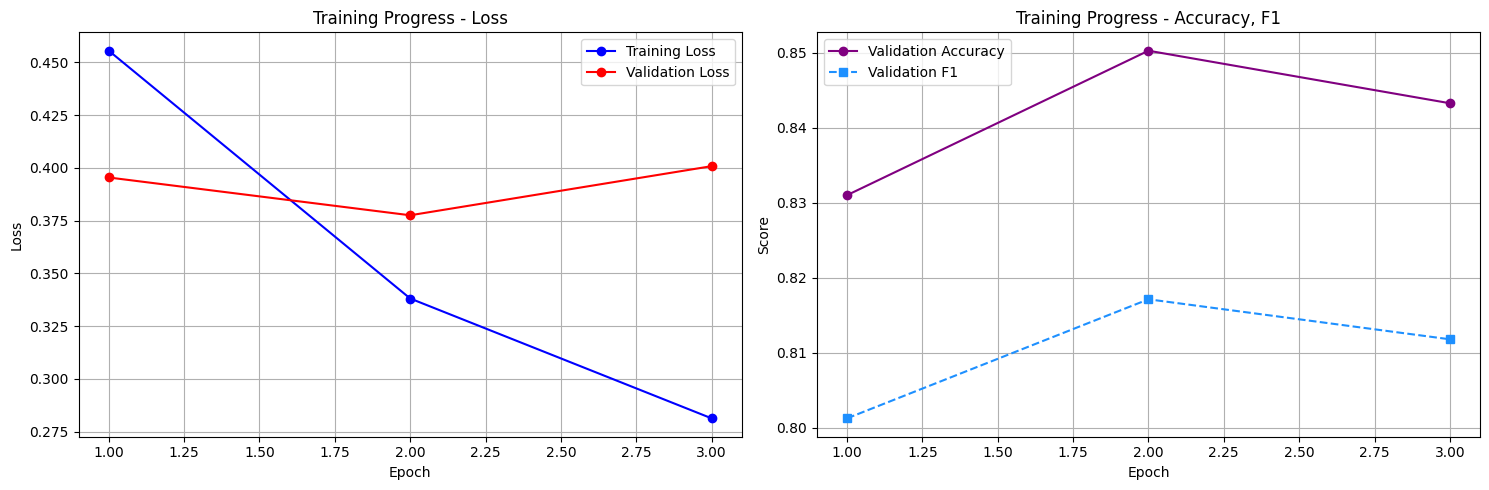


 Generate Test Set Predictions


Predicting:   0%|          | 0/102 [00:00<?, ?it/s]

✅ Generated 3263 predictions
Prediction distribution:
  Not Disaster: 2021 (61.9%)
  Disaster: 1242 (38.1%)
✅ Predictions saved to predictions.csv


In [ ]:
if __name__ == "__main__":
    print("=" * 55)

    trained_model = main()